In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.interpolate import BSpline, splev, interp1d
plt.rcParams['font.size'] = 12.0

In [2]:
H0 = 2.268543540763823e-18   # Hubble's constant: [(km/s)/Mpc]
c  = 2.99792458e8            # Speed of light: [m/s]
Ωb = 0.046
Ωm = 0.224
Ωr = 8.3e-5
ΩΛ = 1.0 - Ωb - Ωm - Ωr
m2Mpc = 3.24078e-23
k = 3

In [3]:
GRID_DURING = 200
GRID_AFTER = 300
GRID_TOTAL = GRID_DURING + GRID_AFTER

REDSHIFT_START = 1630.4
REDSHIFT_END = 614.2

XSTART = -math.log(1.0 + REDSHIFT_START)
XEND = -math.log(1.0 + REDSHIFT_END)
X0 = 0.0

CONFORMAL_N = 1000
SCALE_FAC_0 = 1.0e-10
CONFORMAL_START = math.log(SCALE_FAC_0)
CONFORMAL_END = 0.0

In [4]:
def getH(x):
    """Computes the Hubble parameter H given some x"""
    return H0*math.sqrt((Ωb + Ωm)*math.exp(-3.0*x) + Ωr*math.exp(-4.0*x) + ΩΛ)

def getHPrime(x):
    """Function for H prime e.g. H' = aH"""
    return H0*math.sqrt((Ωb + Ωm)*math.exp(-x) + Ωr*math.exp(-2.0*x) + ΩΛ*math.exp(2.0*x))

def getdHPrime(x):
    return .5*math.exp(x)*H0*(-(Ωb + Ωm)*math.exp(2.0*x) - 2.0*Ωr*math.exp(-3.0*x) + 2.0*ΩΛ*math.exp(x))/math.sqrt( ((Ωb + Ωm)/math.exp(x)) + Ωr*math.exp(-2.0*x) + ΩΛ*math.exp(2.0*x))

def ηDeriv(t, x):
    """Called by odeint when solving for the conformal time eta"""
    return c/getHPrime(x)

def getη(x):
    """Interpolates a value from the differential equation
     solution η using values from the conformal_grid array"""
    return η_spline(x)

def getΩb(x):
    """Computes the value of the baryon density parameter (omega_b) at some x"""
    return Ωb*math.exp(-3.0*x)*((H0/getH(x))**2.0)

def getΩm(x):
    """Computes the dark matter density parameter (omega_m) at x"""
    return Ωm*math.exp(-3.0*x)*((H0/getH(x))**2.0)

def getΩr(x):
    """Computes radiation density (omega_r) at x"""
    return Ωr*math.exp(-4.0*x)*((H0/getH(x))**2.0)

def getΩΛ(x):
    """Computes the dark energy parameter (omega_lambda) at x;
     it is the difference between 1 and the sum of the other parameters"""
    return 1.0 - (getΩb(x) + getΩm(x) + getΩr(x))

In [5]:
x_grid = np.linspace(XSTART, XEND, GRID_DURING, endpoint=True)
x_grid = np.append(x_grid, np.linspace(XEND, X0, GRID_AFTER, endpoint=True))

conformal_grid  = np.linspace(CONFORMAL_START, CONFORMAL_END, CONFORMAL_N, endpoint=True)

In [6]:
η_ini = c*SCALE_FAC_0/(H0*math.sqrt(Ωr))
η = odeint(ηDeriv, η_ini, conformal_grid)

η_spline = BSpline(conformal_grid, η, k=k)

In [7]:
η_grid = np.zeros(GRID_TOTAL)
hubble = np.zeros(GRID_TOTAL)
Ωb_grid = np.zeros(GRID_TOTAL)
Ωm_grid = np.zeros(GRID_TOTAL)
Ωr_grid = np.zeros(GRID_TOTAL)
ΩΛ_grid = np.zeros(GRID_TOTAL)

for i in range(len(x_grid)):
    η_grid[i] = getη(x_grid[i])*m2Mpc
    hubble[i] = getH(x_grid[i])
    Ωb_grid[i] = getΩb(x_grid[i])
    Ωm_grid[i] = getΩm(x_grid[i])
    Ωr_grid[i] = getΩr(x_grid[i])
    ΩΛ_grid[i] = getΩΛ(x_grid[i])

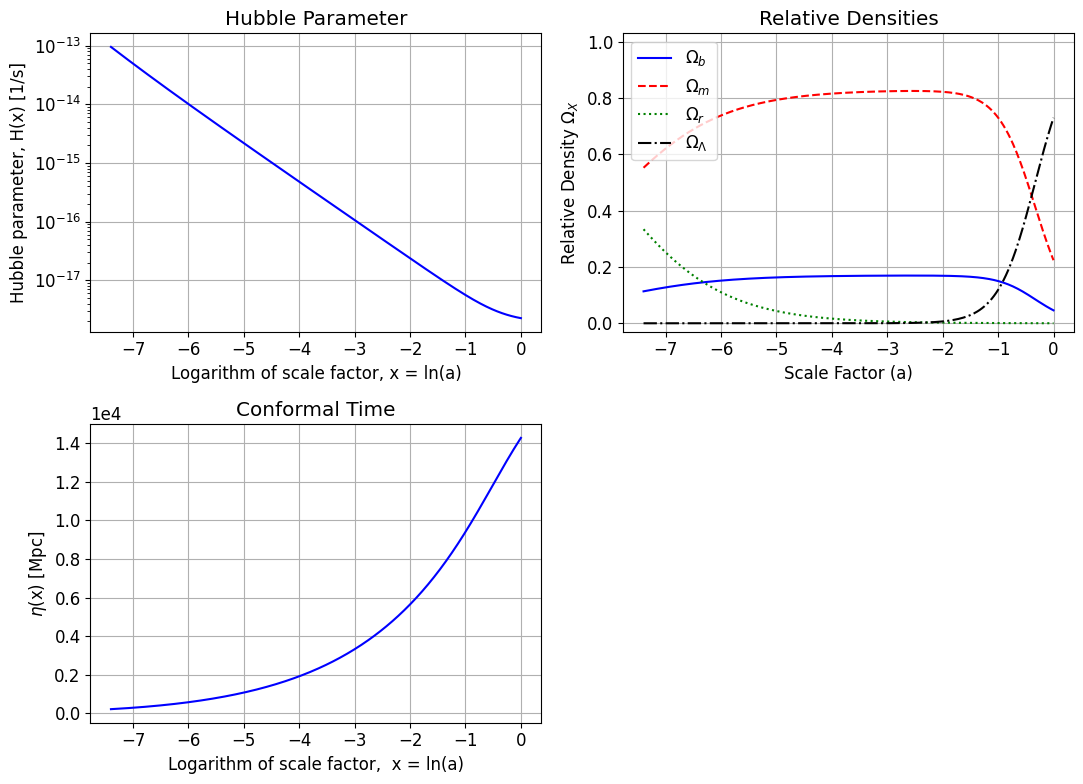

In [9]:
'''
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(11, 8), dpi=100)

axs[0, 0].plot(x_grid, hubble, 'b')
axs[0, 0].set_yscale('log')
axs[0, 0].set_title('Hubble Parameter')
axs[0, 0].set_xlabel('Logarithm of scale factor, x = ln(a)')
axs[0, 0].set_ylabel('Hubble parameter, H(x) [1/s]')
axs[0, 0].grid()


axs[0, 1].plot(x_grid, Ωb_grid, color='blue')
axs[0, 1].plot(x_grid, Ωm_grid, ls='--', color='red')
axs[0, 1].plot(x_grid, Ωr_grid, ls=':', color='green')
axs[0, 1].plot(x_grid, ΩΛ_grid, ls='-.', color='black')
axs[0, 1].set_ylim(-.03, 1.03)
axs[0, 1].set_title('Relative Densities')
axs[0, 1].set_xlabel('Scale Factor (a)')
axs[0, 1].set_ylabel('Relative Density $\Omega_X$')
axs[0, 1].legend(['$\Omega_b$', '$\Omega_m$', '$\Omega_r$', '$\Omega_\Lambda$'], loc='upper left', prop={'size':12})
axs[0, 1].grid()


axs[1, 0].plot(x_grid, η_grid, 'b')
axs[1, 0].set_title('Conformal Time')
axs[1, 0].set_xlabel('Logarithm of scale factor,  x = ln(a)')
axs[1, 0].set_ylabel("$\eta$(x) [Mpc]")
axs[1, 0].ticklabel_format(axis='y', style='sci', scilimits=(0, 0))
axs[1, 0].grid()


axs[1, 1].remove()

fig.tight_layout()
plt.show()
'''